## Libraries

In [ ]:
from google.colab import drive
drive.mount("/content/driver")

Mounted at /content/driver


In [ ]:
pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 492.2/492.2 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 20.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 25.9 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import pickle
!pip install contractions
import contractions
import re
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from datasets import load_dataset

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.8/110.8 kB 14.3 MB/s eta 0:00:00


In [ ]:
dataset=load_dataset("dair-ai/emotion")

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [ ]:
train_data=dataset['train']

In [ ]:
test_data=dataset['test']

In [ ]:
val_data=dataset['validation']

In [ ]:
train_data = pd.DataFrame({'text':train_data['text'],'emotion':train_data['label']})

In [ ]:
val_data = pd.DataFrame({'text':val_data['text'],'emotion':val_data['label']})

In [ ]:
test_data = pd.DataFrame({'text':test_data['text'],'emotion':test_data['label']})


## EDA

In [ ]:
data = {'Train Data': train_data, 'Validation Data': val_data, 'Test Data': test_data}
for temp in data:
    print(temp)
    print(data[temp].isnull().sum())
    print('*'*20)

Train Data
text       0
emotion    0
dtype: int64
********************
Validation Data
text       0
emotion    0
dtype: int64
********************
Test Data
text       0
emotion    0
dtype: int64
********************


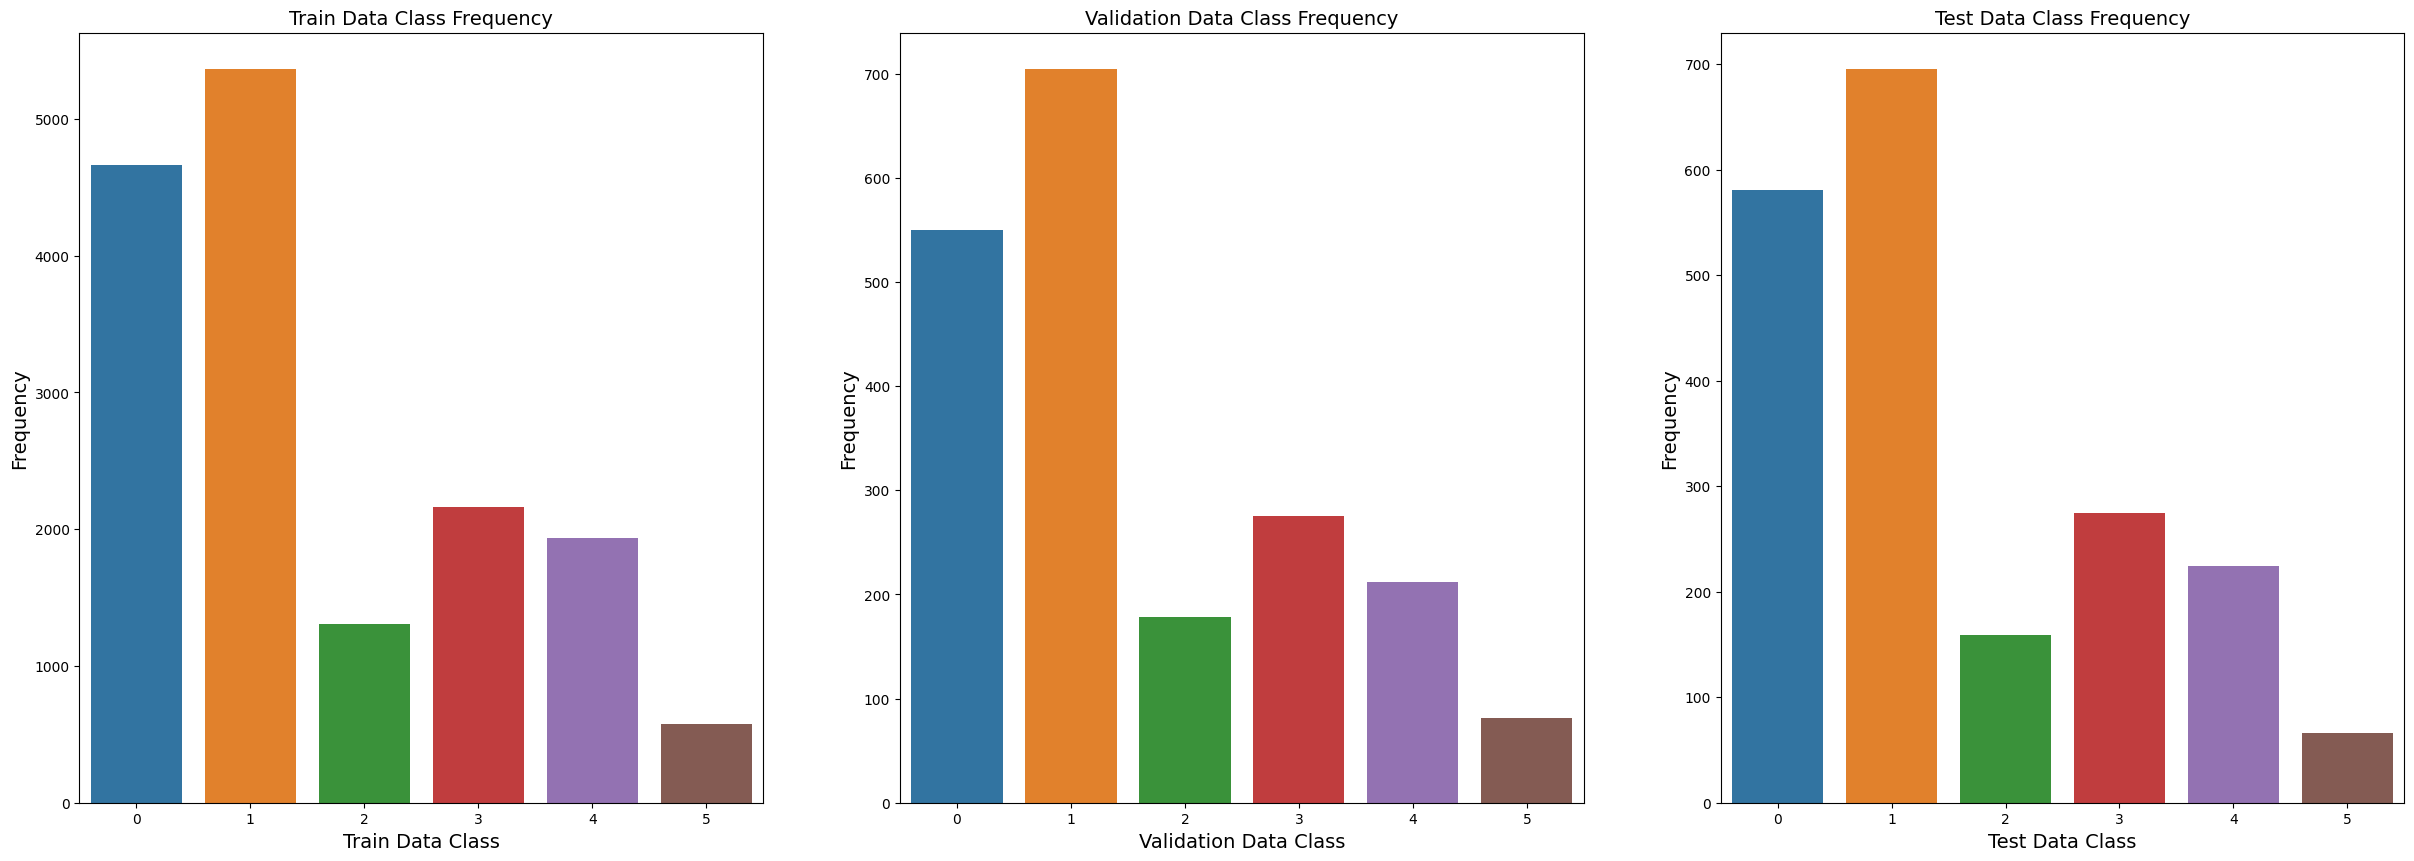

In [ ]:
bar, ax = plt.subplots(1,3, figsize=(30, 10))
for index, temp in enumerate(data):
    sns.countplot(ax = ax[index],x = 'emotion', data = data[temp])
    ax[index].set_title(temp+' Class Frequency', size=14)
    ax[index].set_ylabel('Frequency', size=14)
    ax[index].set_xlabel(temp+' Class', size=14)

In [ ]:
def plot_cloud(wordcloud, temp):
    plt.figure(figsize=(10, 10))
    plt.title(temp+' Word Cloud', size = 16)
    plt.imshow(wordcloud)
    # No axis details
    plt.axis("off");

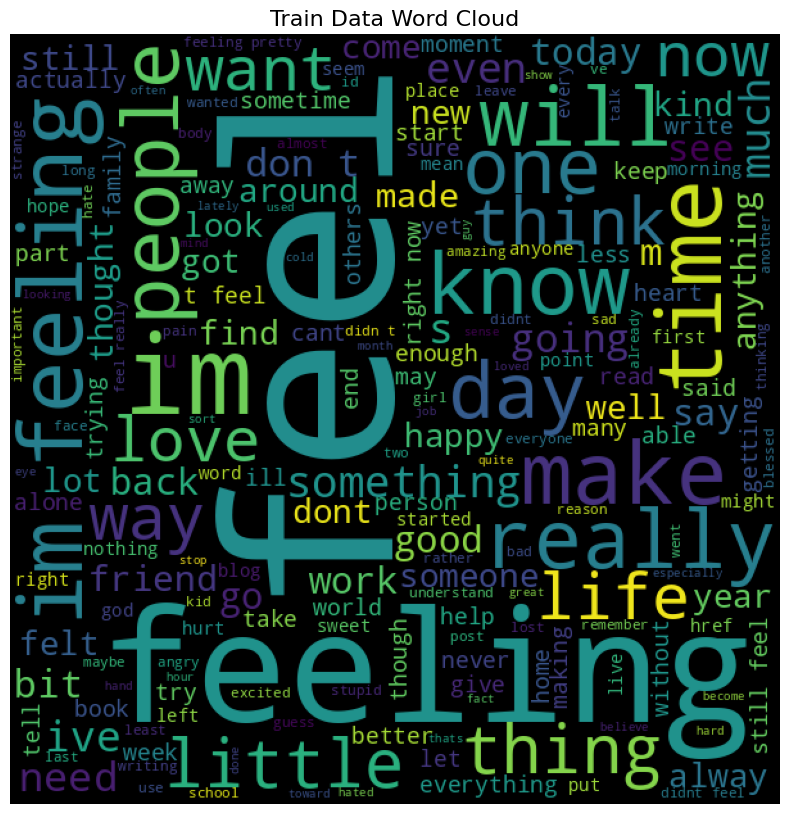

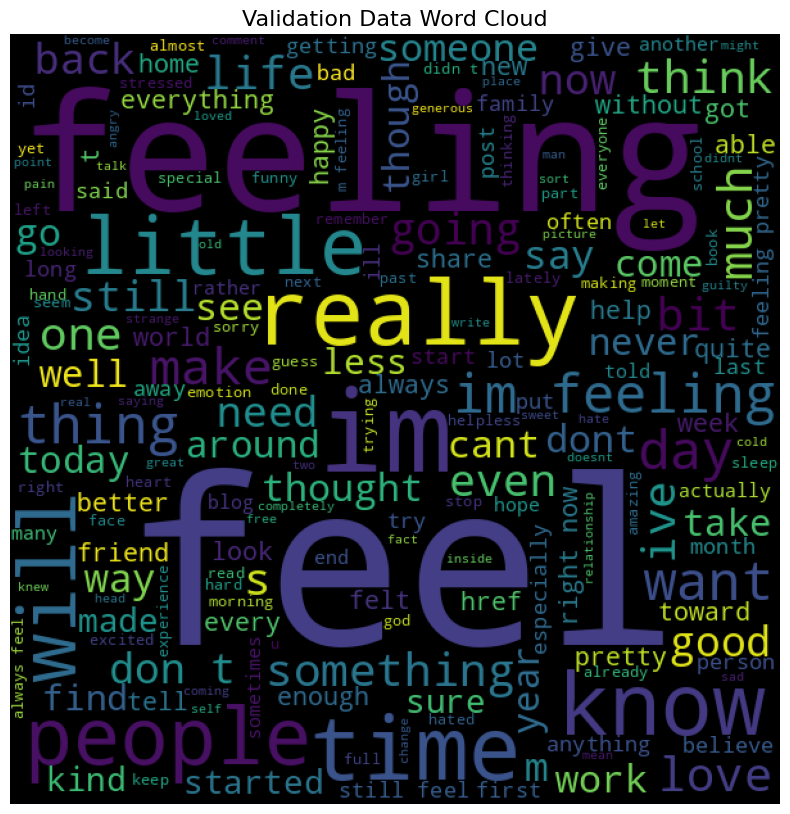

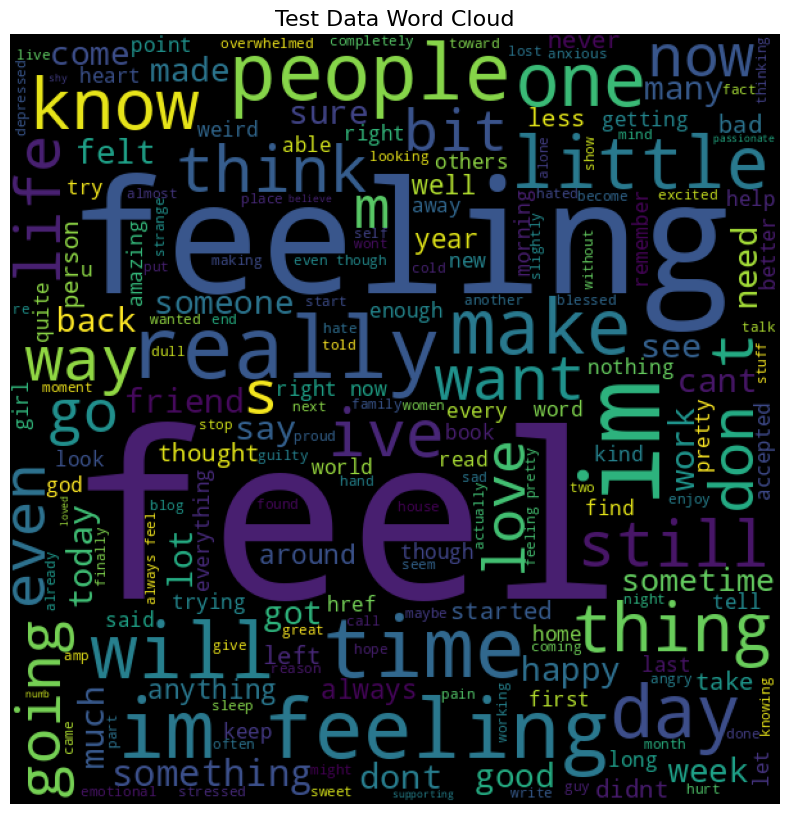

In [ ]:
for temp in data:
    temp_text = ' '.join([sentence for sentence in data[temp].text])
    wordcloud = WordCloud(width = 600, height = 600).generate(temp_text)
    plot_cloud(wordcloud, temp)

# Data Pre-Processing

In [ ]:
def preprocess(sentence):
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    sentence = re.sub('[^A-z]', ' ', sentence)
    negative = ['not', 'neither', 'nor', 'but', 'however', 'although', 'nonetheless', 'despite', 'except',
                        'even though', 'yet']
    stop_words = [z for z in stop_words if z not in negative]
    preprocessed_tokens = [lemmatizer.lemmatize(contractions.fix(temp.lower())) for temp in sentence.split() if temp not in stop_words] #lemmatization
    return ' '.join([x for x in preprocessed_tokens]).strip()


In [ ]:
train_data['text'] = train_data['text'].apply(lambda x: preprocess(x))
val_data['text'] = val_data['text'].apply(lambda x: preprocess(x))
test_data['text'] = test_data['text'].apply(lambda x: preprocess(x))

In [ ]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=0)
train_x, train_y = ros.fit_resample(np.array(train_data['text']).reshape(-1, 1), np.array(train_data['emotion']).reshape(-1, 1))
train = pd.DataFrame(list(zip([x[0] for x in train_x], train_y)), columns = ['text', 'emotion'])

In [ ]:
from sklearn import preprocessing
le = preprocessing.OneHotEncoder()
y_train= le.fit_transform(np.array(train['emotion']).reshape(-1, 1)).toarray()
y_test= le.fit_transform(np.array(test_data['emotion']).reshape(-1, 1)).toarray()
y_val= le.fit_transform(np.array(val_data['emotion']).reshape(-1, 1)).toarray()

# Encoding

In [ ]:
pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 28.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 82.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 33.8 MB/s eta 0:00:00


In [ ]:
from transformers import RobertaTokenizerFast
tokenizer = RobertaTokenizerFast.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment-latest")

In [ ]:
def roberta_encode(data,maximum_length) :
  input_ids = []
  attention_masks = []


  for i in range(len(data.text)):
      encoded = tokenizer.encode_plus(

        data.text[i],
        add_special_tokens=True,
        max_length=maximum_length,
        pad_to_max_length=True,

        return_attention_mask=True,

      )

      input_ids.append(encoded['input_ids'])
      attention_masks.append(encoded['attention_mask'])
  return np.array(input_ids),np.array(attention_masks)

In [ ]:
max_len = max([len(x.split()) for x in train_data['text']])
train_input_ids,train_attention_masks = roberta_encode(train, max_len)
test_input_ids,test_attention_masks = roberta_encode(test_data, max_len)
val_input_ids,val_attention_masks = roberta_encode(val_data, max_len)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2393: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


## Create Model

In [ ]:
def create_model(bert_model, max_len):
    input_ids = tf.keras.Input(shape=(max_len,),dtype='int32')
    attention_masks = tf.keras.Input(shape=(max_len,),dtype='int32')

    output = bert_model([input_ids,attention_masks])
    output = output[1]

    output = tf.keras.layers.Dense(6, activation='softmax')(output)
    model = tf.keras.models.Model(inputs = [input_ids,attention_masks],outputs = output)
    model.compile(Adam(learning_rate=2e-5), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
from transformers import TFRobertaModel
roberta_model = TFRobertaModel.from_pretrained('cardiffnlp/twitter-roberta-base-sentiment-latest')

All model checkpoint layers were used when initializing TFRobertaModel.

All the layers of TFRobertaModel were initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


In [ ]:
model = create_model(roberta_model, max_len)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 43)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 43)]         0           []                               
                                                                                                  
 tf_roberta_model (TFRobertaMod  TFBaseModelOutputWi  124645632  ['input_1[0][0]',                
 el)                            thPoolingAndCrossAt               'input_2[0][0]']                
                                tentions(last_hidde                                               
                                n_state=(None, 43,                                            

## Model Train

In [ ]:
history = model.fit([train_input_ids,train_attention_masks], y_train, validation_data=([val_input_ids,val_attention_masks], y_val), epochs=4,batch_size=32)

Epoch 1/4
1006/1006 [==============================] - 382s 322ms/step - loss: 0.3093 - accuracy: 0.8859 - val_loss: 0.1817 - val_accuracy: 0.9300
Epoch 2/4
1006/1006 [==============================] - 297s 296ms/step - loss: 0.1142 - accuracy: 0.9543 - val_loss: 0.1410 - val_accuracy: 0.9410
Epoch 3/4
1006/1006 [==============================] - 297s 295ms/step - loss: 0.0851 - accuracy: 0.9670 - val_loss: 0.1793 - val_accuracy: 0.9360
Epoch 4/4
1006/1006 [==============================] - 299s 298ms/step - loss: 0.0633 - accuracy: 0.9755 - val_loss: 0.2133 - val_accuracy: 0.9315


In [ ]:
with open("/content/driver/MyDrive/Colab Notebooks/train_model.pkl","wb") as file:
  pickle.dump(history,file)

/usr/local/lib/python3.10/dist-packages/transformers/generation/tf_utils.py:465: UserWarning: `seed_generator` is deprecated and will be removed in a future version.
  warnings.warn("`seed_generator` is deprecated and will be removed in a future version.", UserWarning)


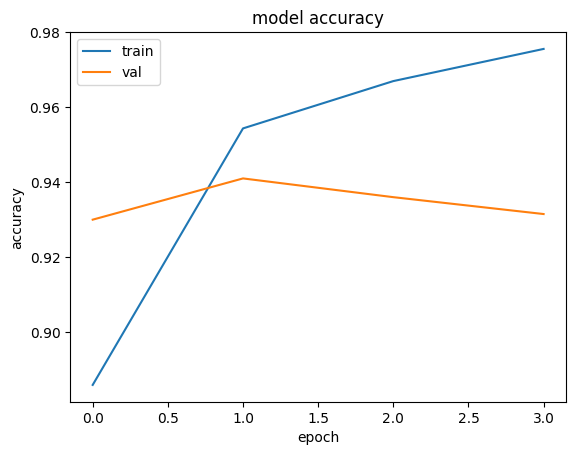

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

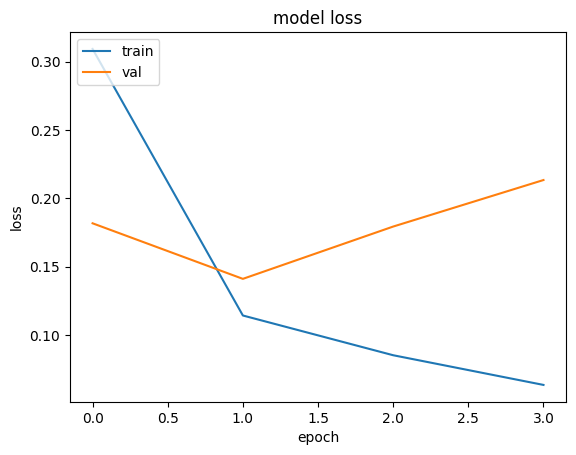

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
result = model.predict([test_input_ids,test_attention_masks])
y_pred = np.zeros_like(result)
y_pred[np.arange(len(result)), result.argmax(1)] = 1

63/63 [==============================] - 10s 111ms/step


In [ ]:
from sklearn.metrics import accuracy_score, classification_report, multilabel_confusion_matrix
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy ', accuracy*100)
report = classification_report(y_test, y_pred)
print("classification Report : ","\n",report)

Accuracy  92.25
classification Report :  
               precision    recall  f1-score   support

           0       0.97      0.96      0.97       581
           1       0.99      0.90      0.94       695
           2       0.77      0.97      0.86       159
           3       0.92      0.90      0.91       275
           4       0.81      0.92      0.87       224
           5       0.77      0.80      0.79        66

   micro avg       0.92      0.92      0.92      2000
   macro avg       0.87      0.91      0.89      2000
weighted avg       0.93      0.92      0.92      2000
 samples avg       0.92      0.92      0.92      2000



In [ ]:
cm = multilabel_confusion_matrix(y_test, y_pred)
print(cm)

[[[1401   18]
  [  22  559]]

 [[1299    6]
  [  70  625]]

 [[1794   47]
  [   5  154]]

 [[1704   21]
  [  28  247]]

 [[1729   47]
  [  17  207]]

 [[1918   16]
  [  13   53]]]


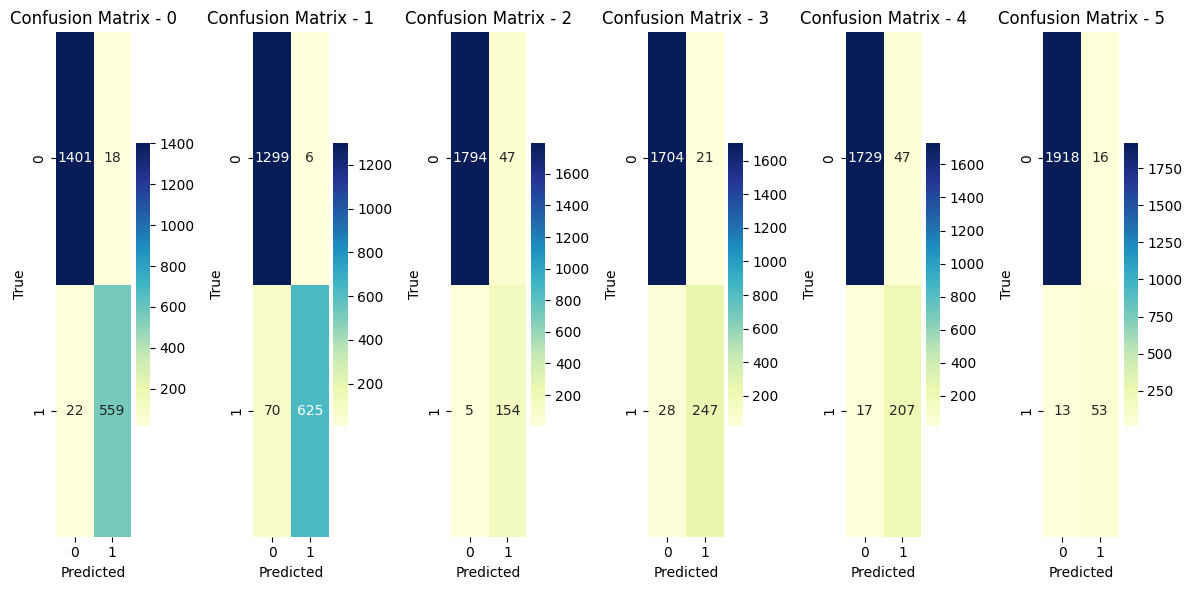

In [ ]:
plt.figure(figsize=(12, 6))
for i, label in enumerate(le.categories_[0]):
    plt.subplot(1, len(le.categories_[0]), i+1)
    sns.heatmap(cm[i], annot=True, cmap='YlGnBu', fmt='g')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix - {}'.format(label))

plt.tight_layout()
plt.show()

In [ ]:
# Save the weights
model.save_weights('my_checkpoint')

## Model Inference

In [ ]:
def plot_result(result):
    sns.barplot(x = 'Category', y = 'Confidence', data = result)
    plt.xlabel('Categories', size=14)
    plt.ylabel('Confidence', size=14)
    plt.title('Emotion Classification', size=16)

In [ ]:
def roberta_inference_encode(data,maximum_length) :
    input_ids = []
    attention_masks = []
    encoded = tokenizer.encode_plus(
    data,
    add_special_tokens=True,
    max_length=maximum_length,
    pad_to_max_length=True,
    return_attention_mask=True)

    input_ids.append(encoded['input_ids'])
    attention_masks.append(encoded['attention_mask'])
    return np.array(input_ids),np.array(attention_masks)

In [ ]:
def inference(text_sentence, max_len):
    preprocessed_text = preprocess(text_sentence)
    input_ids, attention_masks = roberta_inference_encode(preprocessed_text, maximum_length = max_len)
    model = create_model(roberta_model, 43)
    model.load_weights('my_checkpoint')
    result = model.predict([input_ids, attention_masks])
    le.categories_[0] = ['anger','fear','joy','love','sadness','surprise']
    result = pd.DataFrame(dict(zip(list(le.categories_[0]), [round(x*100, 2)for x in result[0]])).items(), columns = ['Category', 'Confidence'])
    plot_result(result)
    return result

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2393: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


1/1 [==============================] - 4s 4s/step
   Category  Confidence
0     anger        0.66
1      fear        7.78
2       joy       80.62
3      love        8.88
4   sadness        1.63
5  surprise        0.43


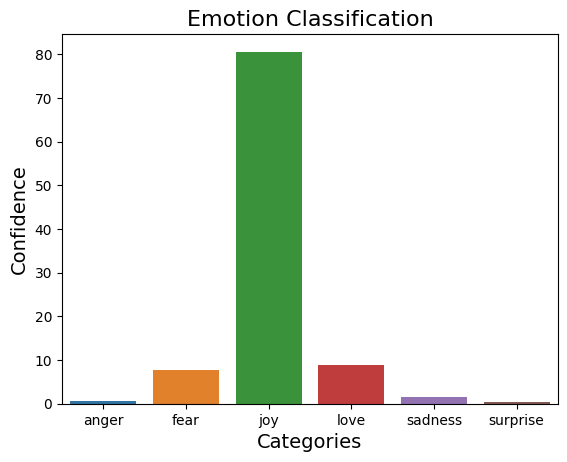

In [ ]:
result = inference("Smile", max_len)
print(result)